# Barebones Triple Momentum Strategy

This notebook will implement a basic version of the strategy laid out in the SeekingAlpha article entitled "Triple Momentum Investing: Even Higher Returns At Lower Risk" (https://seekingalpha.com/article/4249410-triple-momentum-investing-even-higher-returns-lower-risk)

The idea is a three tiered system of momentum strategies, with triple momentum building on the dual and single momentum strategies that precede it. Each strategy is described loosely as follows (these strategies are simply general guides, and clarifications or adjustments made will be specified later):

Single (Relative) Momentum:
- Simply assessing which securities have the best momentum relative to their universe over the past some number of trading days.

Dual (Absolute & Relative) Momentum:
- Adds a second screening that consists of checking whether the trend of the securities is positive (so of your X selected stocks, are they actually trending up, or are they trending down the least?)

Triple (Macro) Momentum:
- Finally, this strategy adds yet another screening, which is about the macro-momentum of the universe. We want to check if the overall momentum of the universe is not generally declining before we buy.

Our goal will be to compare and analyze each of these three strategies against each other in different situations. To begin, we first export all that we'll need from `backtester` and `siftools` for our strategies.

In [2]:
from sif_project.infrastructure.backtesters import full_backtesters as fb
from sif_project.infrastructure.alpha_eval import apply_metric_func
from sif_project.siftools import sif_utils as su, operators as op, metrics
from sif_project.siftools.abstractalpha import AbstractAlpha
import matplotlib.pyplot as plt
import datetime
plt.rcParams['figure.figsize'] = (15, 9)

In [3]:
import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

We construct our backtesting environment with `FullMultipleBacktester` from the `full_backtesters` module. In this notebook we will look at the period from `1-1-2005` to `1-1-2020`. We want a decently large range with ups and downs because we want to see how each of the strategies perform during different market environments. We will use quarterly, `'Q'`, universe rebalancing. The maximum provided is `200`, and a universe size of the top 500 equities at each universe rebalance date. Since this is momentum, the only factors we really need to consider are `close`, `sector`, etc.

In [6]:
start_date = datetime.datetime(2005, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
backtester = fb.FullMultipleBacktester(
    start_date,
    end_date,
    'Q',
    200,
    500,
    ['close', 'sector', 'equity', 'netinc']

)
backtester.save_local('alpha_research_data.npy')

0

We also want to get the S&P500 data so we can keep track of the indices (for the macro-momentum part of the Triple Momentum method) as a factor named `sp_data`.

In [7]:
buffered_start_date = su.trading_days_to_date(backtester.start_date, backtester.max_lookback, lookback=True)
sp_data = su.get_sp_close(buffered_start_date, backtester.end_date)
sp_ret = sp_data.pct_change(1)
backtester.add_factor(sp_data, 'sp_data')
print()

Before we dive into the momentum algorithms, I'm going to use the `RoeCombined` strategy from the `new_alpha_research` introductory notebook as a baseline strategy (in addition to just the S&P500 data). If you recall, the `RoeCombined` strategy was not particularly great, so it will serve as a floor for our other strategies (so we know that if we breach the floor, something is probably wrong).

In [8]:
class RoeCombined(AbstractAlpha):
    def __init__(self):
        self.name = 'RoeCombined'
        self.lookback = 160
        self.universe_size = 500
        self.factor_list = ['netinc', 'equity', 'sector']
    
    def generate_day(self, day, data):
        roe = data['netinc'] / data['equity']
        change = op.group_zscore((roe[day] / roe[day - self.lookback]) - 1, data['sector'])
        raw = op.group_zscore(roe[day], data['sector'])
        factor = op.group_zscore(change + raw, data['sector'])
        return op.weight(factor)

For relative momentum, we pretty much just follow the strategy outline detailed above (and in the article). Per the suggestion of the source article, we only re-check momentums every three trading weeks (15 days) in order to reduce noise. In between these re-checks, we lock in our holdings with the `lock_holdings` function. Furthermore, we only buy the top 5% of stocks based on momentum. Both of these numbers are pretty arbitrary and could be fiddled with in parameter optimization. The only thing glossed over in the article was the suggestion buy the top 30 stocks, and only sell them when they fell out of the top 10% (50) of S&P500 stocks. While this was not implemented in this particular notebook, it could potentially be a more advanced addition to the strategy implementation in the future.

In [9]:
import numpy as np
def equal_long(factor):
    long_mask = factor != 0
    weights = np.zeros_like(factor)
    weights[long_mask] = 1. / long_mask.sum()
    return weights

In [10]:
class RelativeMomentum(AbstractAlpha):
    def __init__(self):
        self.name = 'RelativeMomentum'
        self.lookback = 160
        self.universe_size = 500
        self.factor_list = ['close', 'sector']
        self.holdings_lock = None

    def generate_day(self, day, data):
    
        # How often momentum is checked, so in this case holdings are locked in for three trading weeks at a time
        lock_len = 15
        
        if self.lock_holdings(lock_len):
            close = data['close']
            momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
            gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
            factor = op.group_zscore(momentum, data['sector'])
            # Only want to buy the top 5% stocks (in terms of relative momentum)
            factor[gain <= 1.96] = 0
            self.weights = equal_long(factor)
            return self.weights
    
        else:
            return self.weights

For dual momentum, we keep the relative momentum side pretty much the same. We introduce two more variables on the absolute momentum side of things. We implement a `recency_check` stop-loss of 8% over each re-check period (3 trading weeks, as you may recall), as well as a `abs_gain` check that stocks haven't fallen 3% or more since the last evalution period. These are two more parameters that could potentially be optimized for greater returns.

In [11]:
class DualMomentum(AbstractAlpha):
    def __init__(self):
        self.name = 'DualMomentum'
        self.lookback = 160
        self.universe_size = 500
        self.factor_list = ['close', 'sector']
        self.holdings_lock = None

    def generate_day(self, day, data):
        
        # How often momentum is checked, so in this case holdings are locked in for three trading weeks at a time
        lock_len = 15
        
        if self.lock_holdings(lock_len):
            close = data['close']
            momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
            gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
            abs_gain = close[day] / close[day - self.lookback] - 1
            recency_check = close[day] / close[day - lock_len] - 1
            
            factor = op.group_zscore(momentum, data['sector'])
            # Only want to buy the top 5% stocks (in terms of relative momentum)
            factor[gain <= 1.96] = 0
            # Filter out stocks with a 3% loss or greater since the last evaluation period (3% noise buffer)
            factor[abs_gain <= -0.03] = 0
            # Filter out stocks with a 8% loss or greater over the last 3 weeks (stop-loss over holding lock period)
            factor[recency_check <= -0.08] = 0
            self.weights = equal_long(factor)
            return self.weights
        else:
            return self.weights

Finally, we have the triple momentum strategy. The only difference here is that we implement a check to see if the S&P500 index has fallen a certain percentage (`macro_ratio`) during some specified period of time (`macro_len`). These are the final two variables that might be alterable to achieve higher growth under the triple momentum algorithm. When this is noted to be true, all holdings are immediately sold off until the next re-check.

In [12]:
class TripleMomentum(AbstractAlpha):
    def __init__(self):
        self.name = 'TripleMomentum'
        self.lookback = 160
        self.universe_size = 500
        self.factor_list = ['close', 'sector', 'sp_data']
        self.holdings_lock = None

    def generate_day(self, day, data):
        # How often momentum is checked, so in this case holdings are locked in for three trading weeks at a time
        lock_len = 15
        #How how many days we want the lookback for the entire S&P500 to be
        macro_len = 200
        # How big of a percentage drop we require to sell all our assests
        macro_ratio = 0.04
        
        close = data['close']
        sp_index = data['sp_data']
        momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
        
        if self.lock_holdings(lock_len):
            if sp_index[day] / sp_index[day - macro_len] <= 1-macro_ratio:
                momentum[:] = 0
                factor = op.group_zscore(momentum, data['sector'])
                
            else:
                gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
                abs_gain = close[day] / close[day - self.lookback] - 1
                recency_check = close[day] / close[day - lock_len] - 1
                
                factor = op.group_zscore(momentum, data['sector'])
                # Only want to buy the top 5% stocks (in terms of relative momentum)
                factor[gain <= 1.96] = 0
                # Filter out stocks with a 3% loss or greater since the last evaluation period (3% noise buffer)
                factor[abs_gain <= -0.03] = 0
                # Filter out stocks with a 8% loss or greater over the last 3 weeks (stop-loss over holding lock period)
                factor[recency_check <= -0.08] = 0
                
            self.weights = equal_long(factor)
            return self.weights
        
        else:
            return self.weights

Now we perform backtesting for each of our Alpha strategies.

In [13]:
alphas =  [
    RoeCombined(),
    RelativeMomentum(),
    DualMomentum(),
    TripleMomentum()
    ]
returns, holdings = backtester.backtest(alphas, processes=None)

TripleMomentum: 100%|██████████| 4/4 [03:42<00:00, 55.59s/it]  


We need to fix the dimensions of S&P500 data before we can do any plotting (note that we had a buffered start date for this data earlier, which is why we need to do this).

In [14]:
sp_data = su.get_sp_close(start_date, end_date)
sp_ret = sp_data.pct_change()

We apply a cumulative sum to the returns, and plot the graph over time, while using the S&P500 data as a performance benchmark. We note each of the momentum strategies' improvements over not only the benchmark `RoeCombined` strategy, but the S&P500 as a whole as well. Furthermore, the stop loss of the triple momentum proved to be useful in the 2008-2009 recession (as well as other bearish economies). And during more bullish periods, the momentum strategies pulled away from the S&P500.

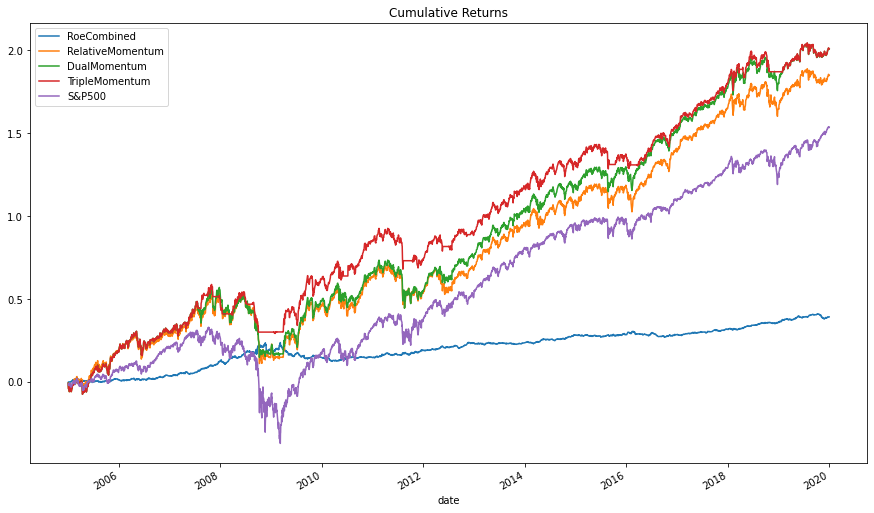

In [15]:
returns.cumsum().plot()
sp_ret.cumsum().plot(label='S&P500')
plt.legend(labels=['RoeCombined', 'RelativeMomentum', 'DualMomentum', 'TripleMomentum', 'S&P500'])
plt.title('Cumulative Returns')
plt.show()

We create summary plots of the different strategies so we can see how they vary individually over time.

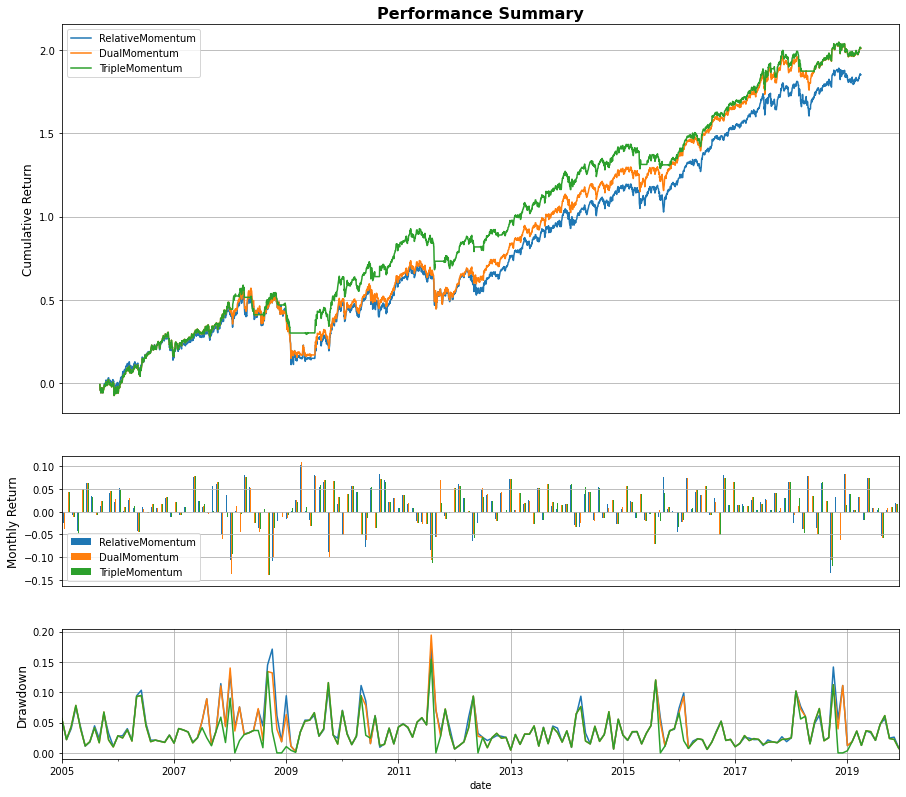

In [16]:
metrics.summary_plot(returns[['RelativeMomentum', 'DualMomentum', 'TripleMomentum']], source=['RelativeMomentum', 'DualMomentum', 'TripleMomentum'])

We use `apply_metric_func` from `alpha_eval` and `generate_performance_table` from `metrics` to produce a summary analytics for each strategy, to more closely compare their performance.

In [17]:
from IPython.core import display as ICD
perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
for alpha, table in zip(alphas, perf_tables):
    print(f"{alpha.name}")
    ICD.display(table)
    print()

RoeCombined


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2005,0.013877,0.626150,1.061058,0.021343,0.051085,234.746032,252.817460
2006,0.022645,0.983960,1.660963,0.013039,0.049942,215.402390,273.565737
2007,0.087178,3.658572,7.069017,0.013225,0.051576,248.107570,240.250996
2008,0.064653,0.894485,0.848180,0.063561,0.047706,247.150198,242.972332
2009,-0.040532,-0.803963,-0.992889,0.095392,0.052362,297.269841,197.956349
2010,0.000429,0.017324,0.024489,0.023226,0.047834,234.523810,255.253968
2011,0.043826,1.491091,2.555387,0.014669,0.046209,240.880952,251.353175
2012,0.044812,2.093773,3.821429,0.017426,0.052521,224.200000,250.352000
2013,0.000621,0.033627,0.050380,0.013014,0.049871,226.829365,265.329365



RelativeMomentum


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2005,0.179459,1.285096,1.850502,0.085845,0.044511,26.142857,0.0
2006,0.101400,0.722874,1.056652,0.147194,0.066400,23.928287,0.0
2007,0.239291,1.304042,1.710273,0.126457,0.050286,25.266932,0.0
2008,-0.361107,-1.385703,-1.964926,0.345189,0.062288,19.225296,0.0
2009,0.296243,1.609762,2.182026,0.108724,0.065847,20.579365,0.0
2010,0.175949,1.039906,1.350411,0.169251,0.054360,22.857143,0.0
2011,-0.095707,-0.471560,-0.587211,0.239487,0.055553,21.888889,0.0
2012,0.146275,1.096356,1.634061,0.147091,0.066981,20.452000,0.0
2013,0.269272,2.222276,3.296802,0.064077,0.065090,23.869048,0.0



DualMomentum


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2005,0.179157,1.283000,1.814229,0.092196,0.054497,24.071429,0.0
2006,0.121576,0.905475,1.312662,0.138305,0.071822,22.541833,0.0
2007,0.252548,1.440727,1.909126,0.124659,0.062234,23.593625,0.0
2008,-0.376731,-1.776416,-2.558296,0.345831,0.071742,17.015810,0.0
2009,0.308623,1.715676,2.275700,0.119784,0.070206,19.357143,0.0
2010,0.172244,1.089312,1.439494,0.142134,0.062142,21.416667,0.0
2011,-0.112875,-0.561781,-0.685195,0.260112,0.062354,20.753968,0.0
2012,0.210450,1.706462,2.587708,0.097547,0.072386,19.136000,0.0
2013,0.281213,2.364784,3.558610,0.065032,0.068590,23.095238,0.0



TripleMomentum


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2005,0.179157,1.283000,1.814229,0.092196,0.054497,24.071429,0.0
2006,0.121576,0.905475,1.312662,0.138305,0.071822,22.541833,0.0
2007,0.203842,1.458544,1.839506,0.081643,0.080542,19.051793,0.0
2008,-0.203418,-1.482420,-1.788852,0.219197,0.056644,10.130435,0.0
2009,0.316325,1.846655,2.403462,0.119784,0.081160,17.400794,0.0
2010,0.231469,1.436262,1.982140,0.110668,0.062892,19.214286,0.0
2011,-0.114527,-0.682551,-0.801910,0.223468,0.050758,18.015873,0.0
2012,0.157832,1.449130,2.126745,0.093643,0.078864,16.796000,0.0
2013,0.281213,2.364784,3.558610,0.065032,0.068590,23.095238,0.0


Finally, we show a 3-year rolling beta against the S&P returns data as a benchmark.

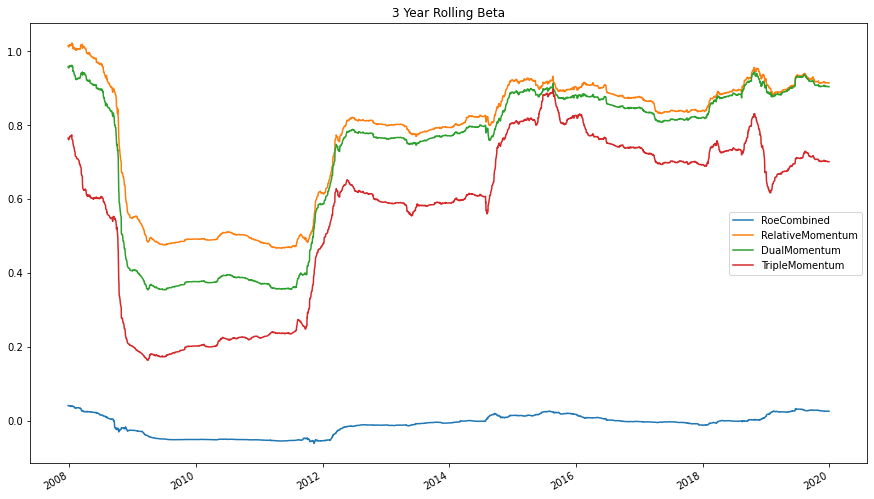

In [25]:
import functools
rolling_beta = functools.partial(metrics.rolling_metric, func=metrics.beta, window=250*3, benchmark_data=sp_ret)
returns.apply(rolling_beta).plot()
plt.title('3 Year Rolling Beta')
plt.show()

__Concluding Thoughts:__

In my view, this strategy has potential for improvement should be looked into more deeply. Specifically, implementing some of the more tricky aspects of the reference material and parameter fine-tuning/optimization (as I specifically noted for each such paramenter several times throughout the notebook) leave potential room for enhancement. Considering the strategy's noteable return improvement over the S&P500 and to some extent the other two momentum strategies, triple momentum will be worth another look at the start of next semester's work.